In [2]:
# !pip install pystan==2.19.1.1
# !pip install prophet
# !pip install plotly


In [6]:
# Python
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import os
os.listdir()
path = open('document.txt', 'r').read().strip()

In [7]:
files = os.listdir(path)
files.sort()
print(files)
print(path + files[0])
test_data_street = files[-1]
files = files[:-2]
print(files)
print(test_data_street)


['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather', '2021_street.feather']
C:\Users\20192638\Documents\Data Challenge 2\street2015_street.feather
['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather']
2021_street.feather


## Notes Police forces
apparently 'Greater Manchester Police' force was removed from 2020 to 2021 <br><br>
'Police Service of Northern Ireland' is included from 2011 onwards

## idea
instead of only count of crimes we can implement a weighted count where more severe crimes have more effect on the total count

In [8]:
def DistrictCrimeData(district, allYears, crime):
    df_district = pd.DataFrame([])
    if allYears:
        for i in files:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within', 'Crime type']]
            df_new = df_new[df_new['Falls within']==district]
            if len(crime) != 0:
                df_new = df_new[df_new['Crime type'].isin(crime)]
            df_district = pd.concat([df_district, df_new], ignore_index=True)
            
    #only last year's data for testing
    else:
        df_district = pd.read_feather(f"{path}/{test_data_street}")
        df_district = df_district[['Month', 'Falls within', 'Crime type']]
        df_district = df_district[df_district['Falls within']==district]
        if len(crime) != 0:
            df_district = df_district[df_district['Crime type'].isin(crime)]

    return df_district

df_data = DistrictCrimeData(district='South Wales Police', allYears=True, crime=['Violence and sexual offences'])
df_test_data = DistrictCrimeData(district='South Wales Police', allYears=False, crime=['Violence and sexual offences'])


In [9]:
df_data['Crime type'].value_counts()


Violence and sexual offences    215068
Name: Crime type, dtype: int64

In [7]:

def Count_by_district(district):
    df_data = pd.DataFrame([])
    for i in files:
        if 'df_data' not in globals():
            df_data = pd.read_feather(f"{path}/{i}")
            df_data = df_data[['Month', 'Falls within']]
            df_data = df_data[df_data['Falls within']==district]
        else:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within']]
            df_new = df_new[df_new['Falls within']==district]
            df_data = pd.concat([df_data, df_new], ignore_index=True)

    return df_data

df_district_count = Count_by_district(district='South Wales Police')
df_district_count.head(5)





,Month,Falls within
0,2015-12,South Wales Police
1,2015-12,South Wales Police
2,2015-12,South Wales Police
3,2015-12,South Wales Police
4,2015-12,South Wales Police


In [10]:
df_test_data.sort_values(by=['Month'])


,Month,Falls within,Crime type
327611,2021-01,South Wales Police,Violence and sexual offences
336057,2021-01,South Wales Police,Violence and sexual offences
336058,2021-01,South Wales Police,Violence and sexual offences
336070,2021-01,South Wales Police,Violence and sexual offences
336071,2021-01,South Wales Police,Violence and sexual offences
...,...,...,...
4850294,2021-10,South Wales Police,Violence and sexual offences
4850295,2021-10,South Wales Police,Violence and sexual offences
4850296,2021-10,South Wales Police,Violence and sexual offences
4850236,2021-10,South Wales Police,Violence and sexual offences


In [11]:
#district = df_data[df_data['Falls within']=='South Wales Police']
#del df_data
district = df_data.copy()
predict = {}

district = district.sort_values(by=['Month'])
months = district['Month'].unique()
for i in months:
    predict[i] = len(district[district['Month']==i])
predict = pd.DataFrame({'ds': list(predict.keys()), 'y': list(predict.values())})
predict['ds'] = pd.to_datetime(predict['ds'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1, 'forecasted trend on violence and sexual offences in South Wales')

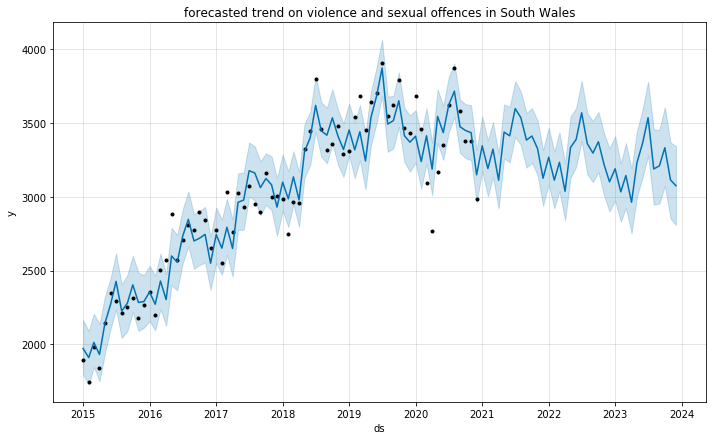

In [12]:
m = Prophet(seasonality_mode='multiplicative').fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title('forecasted trend on violence and sexual offences in South Wales')


(2000, 5000)

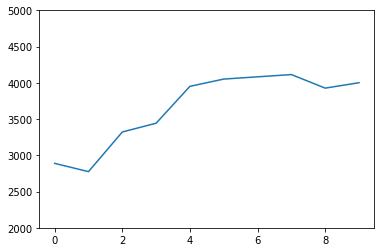

In [13]:
y_data = df_test_data['Month'].value_counts()
y_data = dict(sorted(y_data.items()))

#x_data = y_data.keys().sort_values(by) 

test_data = pd.DataFrame(data = {'Crimes per month' : y_data.values()})

plt.plot(test_data)
plt.ylim(2000, 5000)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


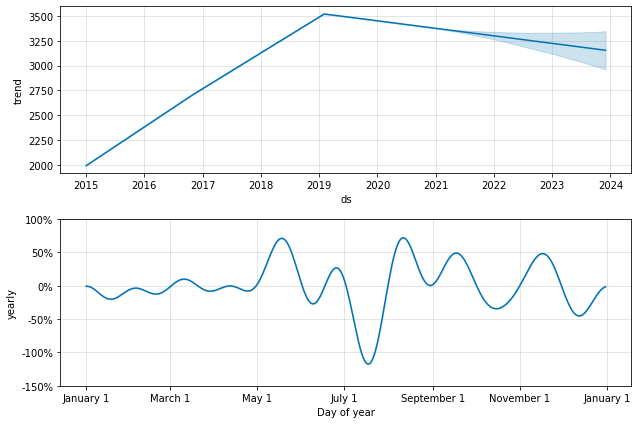

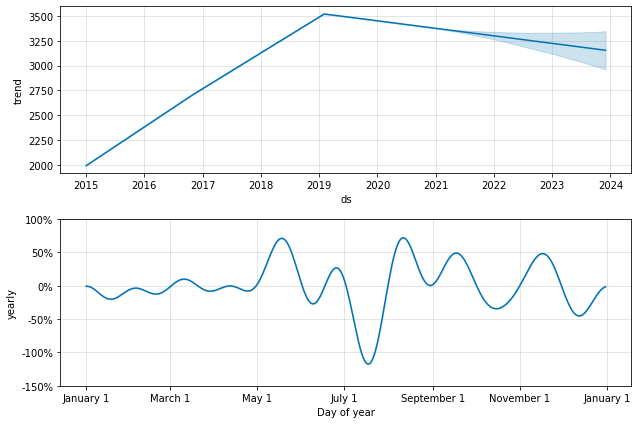

In [14]:
m.plot_components(fcst)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1, 'Prediction of South Wales increase in violence and sexual offences')

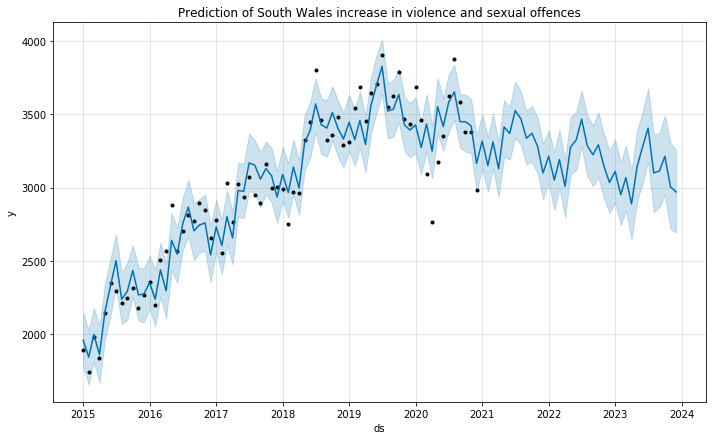

In [15]:
m = Prophet(seasonality_mode='additive').fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title("Prediction of South Wales increase in violence and sexual offences")

In [14]:
# m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(predict)
# fcst = m.predict(future)
# fig = m.plot_components(fcst)

In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2023-08-01,3100.136277,2853.026903,3358.498098
104,2023-09-01,3112.861429,2847.976965,3380.148650
105,2023-10-01,3213.652490,2945.855542,3477.438803
106,2023-11-01,3005.112809,2730.470263,3283.965470
107,2023-12-01,2970.823024,2687.279676,3247.969622


In [16]:
#df_predict = df_data[~df_data.isna()]
#df_predict

In [17]:
#df_data.loc[[129657]]

In [18]:
# df_predict = df_data[['Month', 'Longitude', 'Latitude']].reset_index()
# index = df_predict.pop('index')
# df_predict.insert(1, 'index', index)


# df_predict.columns = ['ds', 'y', 'add1', 'add2']

# df_predict


### Cross validation


In [17]:
cutoffs = pd.date_range(start='2018-02-01', end='2020-01-01', freq='2MS')
print(cutoffs)
df_cv = cross_validation(model=m, initial=1095, horizon='62 days', cutoffs=cutoffs)

DatetimeIndex(['2018-02-01', '2018-04-01', '2018-06-01', '2018-08-01',
               '2018-10-01', '2018-12-01', '2019-02-01', '2019-04-01',
               '2019-06-01', '2019-08-01', '2019-10-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='2MS')


In [18]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-01,3153.439403,3102.191355,3206.528606,2969,2018-02-01
1,2018-04-01,2979.420883,2924.769574,3034.919332,2960,2018-02-01
2,2018-05-01,3215.494556,3157.565817,3273.145475,3322,2018-04-01
3,2018-06-01,3239.764688,3185.924355,3297.693825,3450,2018-04-01
4,2018-07-01,3307.961087,3239.863218,3378.537685,3801,2018-06-01
5,2018-08-01,3225.659738,3161.237032,3294.745577,3464,2018-06-01
6,2018-09-01,3341.078055,3244.407047,3438.855640,3321,2018-08-01
7,2018-10-01,3472.045411,3372.795171,3571.490026,3359,2018-08-01
8,2018-11-01,3307.023103,3198.213892,3407.247118,3484,2018-10-01
9,2018-12-01,3331.058979,3230.525416,3433.354300,3292,2018-10-01


In [19]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p)
df_p['rmse'].mean()

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  34587.349712  185.976745  185.970443  0.056488  0.056488  0.056216   
1 30 days  66213.340954  257.319531  185.277499  0.049761  0.026906  0.052053   
2 31 days  16413.634094  128.115706  106.532322  0.030650  0.025526  0.030416   
3 59 days   6644.259315   81.512326   66.524498  0.019725  0.019725  0.019989   
4 61 days  36129.824456  190.078469  168.419464  0.048090  0.060086  0.047732   
5 62 days  73019.475908  270.221161  266.465221  0.075953  0.075953  0.076981   

   coverage  
0  0.000000  
1  0.500000  
2  0.666667  
3  1.000000  
4  0.250000  
5  0.000000  


185.53732304497498

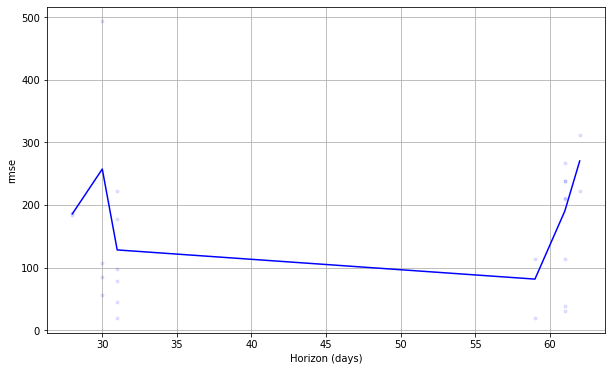

In [21]:
from prophet.plot import plot_cross_validation_metric 
fig = plot_cross_validation_metric(df_cv, metric='rmse')


### Other data aggregation


In [ ]:
df_data0 = pd.read_feather(f"{path}/{files[0]}")
df_data1 = pd.read_feather(f"{path}/{files[1]}")
df_data2 = pd.read_feather(f"{path}/{files[2]}")
df_data3 = pd.read_feather(f"{path}/{files[3]}")
df_data4 = pd.read_feather(f"{path}/{files[4]}")
df_data5 = pd.read_feather(f"{path}/{files[5]}")

In [ ]:

crimes = df_data0['Crime type'].value_counts().keys()
crimeCount0 = df_data0['Crime type'].value_counts()
crimeCount1 = df_data1['Crime type'].value_counts()
crimeCount2 = df_data2['Crime type'].value_counts()
crimeCount3 = df_data3['Crime type'].value_counts()
crimeCount4 = df_data4['Crime type'].value_counts()
crimeCount5 = df_data5['Crime type'].value_counts()
dic0 = dict(zip(crimes, crimeCount0))
dic1 = dict(zip(crimes, crimeCount1))
dic2 = dict(zip(crimes, crimeCount2))
dic3 = dict(zip(crimes, crimeCount3))
dic4 = dict(zip(crimes, crimeCount4))
dic5 = dict(zip(crimes, crimeCount5))
df_crime_distribution = pd.DataFrame(columns=crimes)
df_crime_distribution = df_crime_distribution.append(dic0, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic1, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic2, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic3, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic4, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic5, ignore_index=True)
df_crime_distribution

,Anti-social behaviour,Violence and sexual offences,Criminal damage and arson,Other theft,Burglary,Vehicle crime,Shoplifting,Public order,Drugs,Bicycle theft,Theft from the person,Other crime,Robbery,Possession of weapons
0,1875251,1049161,549145,505583,410576,368568,339123,193944,151248,88163,83092,63224,51628,25162
1,1852894,1233265,571144,497262,409399,394556,362286,254027,137670,86726,83586,74172,56130,31229
2,1712771,1512942,603824,544405,458419,445689,389625,367198,136784,102983,100667,93174,74329,40137
3,1789313,1436624,577112,552890,467788,435702,430086,379399,148270,103570,101242,96848,82621,45848
4,1883205,1311848,549655,520104,447553,436909,384606,359312,175808,110894,103584,88126,87075,46923
5,1869066,1774618,484456,445214,366362,347893,282623,248429,198153,104403,77375,63196,62345,42869


In [ ]:
df_crime_distribution1 = pd.DataFrame(columns=crimes)
df_crime_distribution1 = df_crime_distribution1.append(dic0, ignore_index=True)

In [ ]:
#df_crime_distribution.to_feather(f"C:/Users/Arcane/Documents/Data Challenge 2/extra")

Text(0.5, 1.0, 'Amount of crime for each crime type per year')

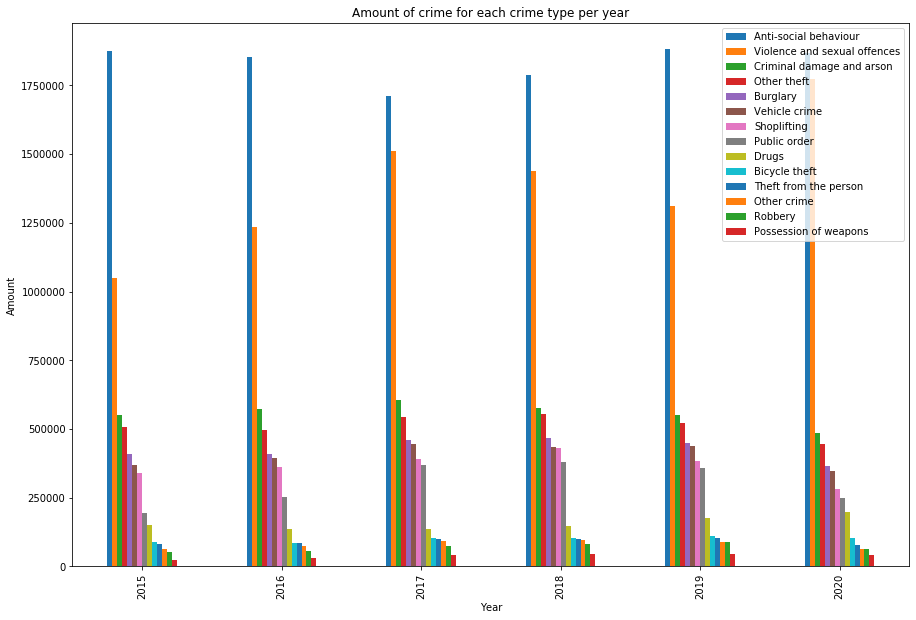

In [ ]:
ax = df_crime_distribution.plot.bar(figsize=(15,10))
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019, 2020])
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('Amount of crime for each crime type per year')


   Total crimes
0       5753868
1       6044346
2       6582947
3       6647313
4       6505602
5       6367002


([<matplotlib.axis.XTick at 0x1a2052a5908>,
 <a list of 6 Text xticklabel objects>)

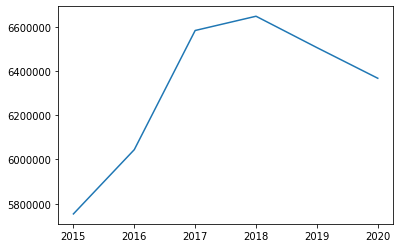

In [ ]:
sum0 = sum(crimeCount0)
sum1 = sum(crimeCount1)
sum2 = sum(crimeCount2)
sum3 = sum(crimeCount3)
sum4 = sum(crimeCount4)
sum5 = sum(crimeCount5)

df_total_crimes = pd.DataFrame(data = {'Total crimes' : [sum0,sum1,sum2,sum3,sum4,sum5]})
print(df_total_crimes)
plt.plot(df_total_crimes)
plt.rcParams["figure.figsize"] = (10,5)
plt.xticks([0, 1, 2, 3, 4, 5], ['2015', '2016', '2017', '2018', '2019', '2020'])

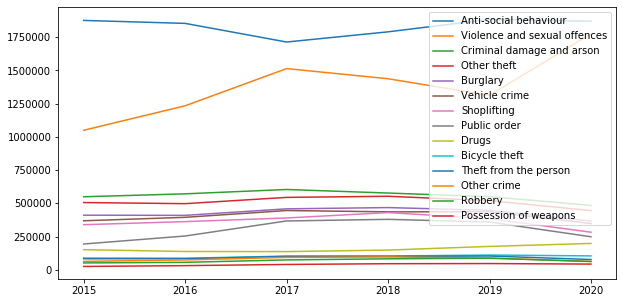

In [ ]:
plt.plot(df_crime_distribution)
plt.rcParams["figure.figsize"] = (15,10)
plt.xticks([0, 1, 2, 3, 4, 5], ['2015', '2016', '2017', '2018', '2019', '2020'])
plt.legend(crimes, loc='upper right')